In [ ]:
### I experimented with conv nets following these empirical guidelines : 

# keeping the 'usual' symetric architecture : conv/maxpool layers
# same kernel size and pooling size across all layers
# smaller kernels : 3x3
# adding layers further into the network : 64, 128, 256
# adding dropout after maxpool, tuning it to 0,25
# increasing batch size (to 256 max, after it decreases acc)
# adding a second fully connected layer 

In [ ]:
### I also experimented on Google Colab (using GPU) (file available on my GitHub)
# https://github.com/petrum01/exts-aml3/blob/master/Convolutional_neural_network.ipynb

# The best result I had with the following conv net was : 
# Epochs : 400
# Batch : 250
# learning rate : 0.0001
# Acc on test set : 0.773

# I did not reproduce it on this notebook because it will take too long on my computer,
# below is the same CNN with
# Epochs : 100
# Batch : 64
# learning rate : 0.0001
# Acc on test set : 0.750

In [1]:
# Load and split the 5000 labeled data points into train, validation and test sets (3200, 800 and 1000 data points)

import numpy as np
import os

# Load the data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    cifar = dict(npz_file.items())

pixels = cifar['pixels']
labels = cifar['labels']

In [2]:
# Rescale pixel values between -0.5 and 0.5
pixels = (pixels - 128) / 255

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the matrix of pixels
X_tr, X_te, y_tr, y_te = train_test_split(pixels.reshape(-1, 32, 32, 3), # de-flatten the matrix of pixels
                                          labels, train_size=4000, test_size=1000, 
                                          stratify=labels, # same class distribution
                                          random_state=0)

print('Train:', X_tr.shape, y_tr.shape)
print('Test:', X_te.shape, y_te.shape)

X_tr2, X_val, y_tr2, y_val = train_test_split(X_tr, y_tr, train_size=3200, test_size=800, 
    stratify=y_tr , # same class distribution
    random_state=0)

print('Train2:', X_tr2.shape, y_tr2.shape)
print('Val:', X_val.shape, y_val.shape)

Train: (4000, 32, 32, 3) (4000,)
Test: (1000, 32, 32, 3) (1000,)
Train2: (3200, 32, 32, 3) (3200,)
Val: (800, 32, 32, 3) (800,)


In [4]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [5]:
# Create a CNN with the following architecture : 

# 1st Conv layer, 64 filters, 3x3 kernel size, stride 1x1, same pading, ReLu
# Max pooling layer 2x2, stride 2x2
# Dropout 0,25

# 2nd Conv layer, 128 filters, 3x3 kernel size, stride 1x1, same pading, ReLu
# Max pooling layer 2x2, stride 2x2
# Dropout 0,25

# 3rd Conv layer, 256 filters, 3x3 kernel size, stride 1x1, same pading, ReLu
# Max pooling layer 2x2, stride 2x2
# Dropout 0,5

# 3 fully connected layers : 256, 512, 256 hidden units, ReLu, 
# Dropout 0,5 after each fcl
# Output layer (4 units) with no activation function

import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Convolutional layer
    conv = tf.layers.conv2d(
        X, # Input data
        filters=64, # 64 filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv' 
    )
    print('Convolutional layer 1',conv.shape)
    
     # Max pooling layer
    pool = tf.layers.max_pooling2d(
        conv, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME' # "same" padding
    )
    print('max pooling 1',pool.shape) 
    
        # Dropout
    training = tf.placeholder(dtype=tf.bool)
    pool = tf.layers.dropout(pool, rate=0.25, seed=0, training=training)
    print('max pooling 1 dropout',pool.shape)
    
     # Convolutional layer
    conv2 = tf.layers.conv2d(
        pool, 128, (3, 3), (1, 1), 'SAME',
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' 
    )
    print('Convolutional layer 2',conv2.shape)

    # Max pooling layer (2x2, stride: 2)
    pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), 'SAME')
    print('max pooling 2',pool2.shape) 

        # Dropout
    pool2 = tf.layers.dropout(pool2, rate=0.25, seed=0, training=training)
    print('max pooling 2 dropout',pool2.shape)
    
    # Convolutional layer
    conv3 = tf.layers.conv2d(
        pool2, 256,(3, 3), (1, 1), 'SAME',
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv3' 
    )
    print('Convolutional layer 3',conv3.shape)

    # Max pooling layer (2x2, stride: 2)
    pool3 = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), 'SAME')
    print('max pooling 3',pool3.shape) 
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool3)

    # Dropout
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)

    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 256, # hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer1:', fc1.shape)
    
    # Dropout
    fc1 = tf.layers.dropout(fc1, rate=0.5, seed=0, training=training)
    print('Dropout:', fc1.shape)
    
    # Fully connected layer
    fc2 = tf.layers.dense(
        fc1, 512, # hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer2:', fc2.shape)
    
    # Dropout
    fc2 = tf.layers.dropout(fc2, rate=0.5, seed=0, training=training)
    print('Dropout:', fc2.shape)
    
    # Fully connected layer
    fc3 = tf.layers.dense(
        fc2, 256, # hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer3:', fc3.shape)
    
    # Dropout
    fc3 = tf.layers.dropout(fc3, rate=0.5, seed=0, training=training)
    print('Dropout:', fc3.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc3, 4, # 4 classes
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Output layer',logits.shape) 

    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv', reuse=True):
        conv_kernels = tf.get_variable('kernel')

        # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

Convolutional layer 1 (?, 32, 32, 64)
max pooling 1 (?, 16, 16, 64)
max pooling 1 dropout (?, 16, 16, 64)
Convolutional layer 2 (?, 16, 16, 128)
max pooling 2 (?, 8, 8, 128)
max pooling 2 dropout (?, 8, 8, 128)
Convolutional layer 3 (?, 8, 8, 256)
max pooling 3 (?, 4, 4, 256)
Dropout: (?, 4096)
Fully-connected layer1: (?, 256)
Dropout: (?, 256)
Fully-connected layer2: (?, 512)
Dropout: (?, 512)
Fully-connected layer3: (?, 256)
Dropout: (?, 256)
Output layer (?, 4)
<tf.Variable 'conv/kernel:0' shape=(3, 3, 3, 64) dtype=float32_ref>
<tf.Variable 'conv/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv2/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'conv2/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'conv3/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>
<tf.Variable 'conv3/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(4096, 256) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'd

In [6]:
%%time
import numpy as np
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(100):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_tr2, y_tr2, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.0001, # Learning rate
                training: True #dropout
            })
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_val,
            y: y_val,
            training: False
        })
        valid_acc_values.append(valid_acc)
        
        # Print progress
        if (epoch+1)%10==0 :
          print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))
       
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_te,
        y: y_te,
            training: False
    })
    print('Test accuracy: {:.3f}'.format(test_acc))

Epoch 10 - valid: 0.466 train: 0.411 (mean)
Epoch 20 - valid: 0.517 train: 0.522 (mean)
Epoch 30 - valid: 0.590 train: 0.616 (mean)
Epoch 40 - valid: 0.660 train: 0.673 (mean)
Epoch 50 - valid: 0.671 train: 0.709 (mean)
Epoch 60 - valid: 0.691 train: 0.767 (mean)
Epoch 70 - valid: 0.720 train: 0.805 (mean)
Epoch 80 - valid: 0.748 train: 0.832 (mean)
Epoch 90 - valid: 0.755 train: 0.870 (mean)
Epoch 100 - valid: 0.743 train: 0.902 (mean)
Test accuracy: 0.750
CPU times: user 2h 27min 1s, sys: 11min 29s, total: 2h 38min 31s
Wall time: 54min 12s


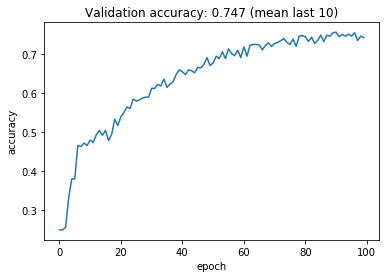

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 10)'.format(
    np.mean(valid_acc_values[-10:]) # last 10 values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

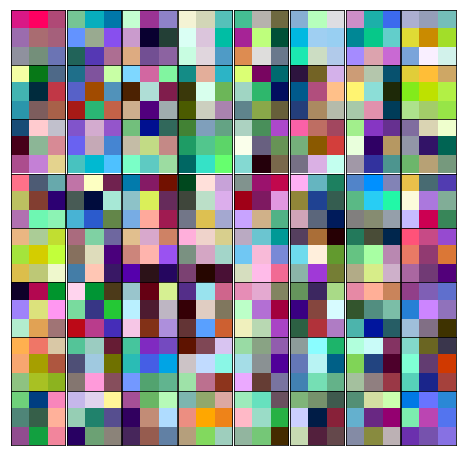

In [9]:
# Plot the trained weights of the kernels from the first convolutional layer.

# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()

In [10]:
# save results
import csv
results = ['Conv Neural Network', test_acc]
with open(r'results.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(results)